Fraction of functional isoforms for novel compared to alternative and reference isoforms

- Try remaking PPI pie chart with only pairs from the screens tested? 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats

from data_loading import (load_valid_isoform_clones,
                          load_isoform_and_paralog_y2h_data,
                          load_y1h_pdi_data,
                          load_annotated_TFiso1_collection,
                          load_m1h_activation_data)

In [2]:
tfs = load_annotated_TFiso1_collection()
mane_select_clones = {tf.MANE_select_isoform.clone_acc for tf in tfs.values() 
                      if tf.cloned_MANE_select_isoform}

reading from cache


In [3]:
iso = load_valid_isoform_clones()
iso['is_longest_isoform'] = iso['clone_acc'].isin(iso.sort_values('num_aa', ascending=False).groupby('gene_symbol').nth(0)['clone_acc'].values)
iso['category'] = 'alternative'
# TODO: remove genes with no mane select isoform
iso.loc[iso['clone_acc'].isin(mane_select_clones), 'category'] = 'reference'
iso.loc[iso['is_novel_isoform'], 'category'] = 'novel'
ppi = load_isoform_and_paralog_y2h_data()
ppi = ppi.loc[ppi['category'] == 'tf_isoform_ppis', :]
pdi = load_y1h_pdi_data()
m1h = load_m1h_activation_data()
iso['valid_ppi_test'] = iso['clone_acc'].map(ppi.groupby('ad_clone_acc').apply(lambda rows: ((rows['Y2H_result'] == True) |
                                                                                             (rows['Y2H_result'] == False))
                                                                                             .any()))
iso['at_least_one_ppi'] = iso['clone_acc'].map(ppi.groupby('ad_clone_acc').apply(lambda rows: (rows['Y2H_result'] == True)
                                                                                               .any()))
pdi = pdi.drop_duplicates('clone_acc')
iso['at_least_one_pdi'] = iso['clone_acc'].map(pdi.drop(columns=['gene_symbol']).set_index('clone_acc').sum(axis=1) > 0)
iso['at_least_two_fold_activation'] = iso['clone_acc'].map(
                                            m1h.drop(columns=['gene_symbol'])
                                                .set_index('clone_acc')
                                                .mean(axis=1)
                                                .abs() > 1)

In [4]:
iso.category.value_counts()

alternative    372
reference      195
novel          191
Name: category, dtype: int64

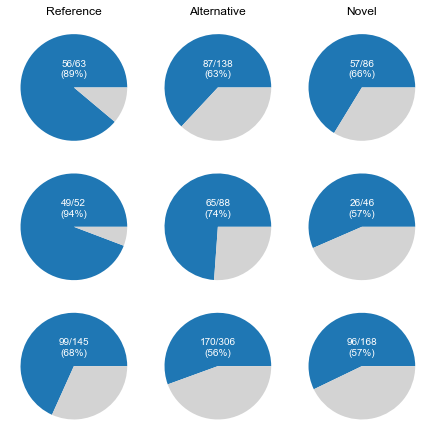

In [5]:
# add numbers and percentage
fig, axes = plt.subplots(3, 3)
fig.set_size_inches(6, 6)
cats = ['reference', 'alternative', 'novel']
for cat, ax in zip(cats, axes[0, :]):
    ax.set_title(cat.capitalize())
    cnt = (iso.loc[iso['valid_ppi_test'] & (iso['category'] == cat),
           'at_least_one_ppi']
       .value_counts())
    cnt.plot.pie(ax=ax,
                 labels=['', ''],
                 colors=['C0', 'lightgrey'])
    ax.text(x=0, 
            y=0.2, 
            s='{}/{}\n({:.0%})'.format(cnt[True], cnt.sum(), cnt[True] / cnt.sum()),
            ha='center',
            color='white')
    ax.set_ylabel('')
for cat, ax in zip(cats, axes[1, :]):
    cnt = (iso.loc[(iso['category'] == cat),
           'at_least_one_pdi']
       .value_counts())
    cnt.plot.pie(ax=ax,
                 labels=['', ''],
                 colors=['C0', 'lightgrey'])
    ax.text(x=0, 
            y=0.2, 
            s='{}/{}\n({:.0%})'.format(cnt[True], cnt.sum(), cnt[True] / cnt.sum()),
            ha='center',
            color='white')
    ax.set_ylabel('')
for cat, ax in zip(cats, axes[2, :]):
    cnt = (iso.loc[(iso['category'] == cat),
           'at_least_two_fold_activation']
       .value_counts())
    cnt.plot.pie(ax=ax,
                 labels=['', ''],
                 colors=['C0', 'lightgrey'])
    ax.text(x=0, 
            y=0.2, 
            s='{}/{}\n({:.0%})'.format(cnt[True], cnt.sum(), cnt[True] / cnt.sum()),
            ha='center',
            color='white')
    ax.set_ylabel('')
plt.savefig('../figures/fraction_positive_by_isoform_type.pdf',
            bbox_inches='tight')

In [6]:
stats.fisher_exact([[50, 20], [26, 20]])

SignificanceResult(statistic=1.9230769230769231, pvalue=0.11318085109977968)

In [7]:
# look at PPI OR PDI OR M1H?
iso.head()

,gene,clone_acc,cds,aa_seq,num_aa,is_novel_isoform,clone_name,is_longest_isoform,category,valid_ppi_test,at_least_one_ppi,at_least_one_pdi,at_least_two_fold_activation
0,AEBP2,AEBP2|2/3|05F03,ATGGATGTAGACAGCACAATTTCCAGTGGGCGTTCAACTCCAGCAA...,MDVDSTISSGRSTPAMMNGQGSTTSSSKNIAYNCCWDQCQACFNSS...,268,True,AEBP2-2,True,novel,NaN,NaN,NaN,False
1,AEBP2,AEBP2|3/3|05E07,ATGTACACACGTCGGTACTCAAGCATAAGCAGTACTATAATGGATG...,MYTRRYSSISSTIMDVDSTISSGRSTPAMMNGQGSTTSSSKNIAYN...,263,True,AEBP2-3,False,novel,NaN,NaN,NaN,False
2,ARNT2,ARNT2|1/6|08C12,ATGGCAACCCCGGCGGCGGTCAACCCTCCGGAAATGGCTTCAGACA...,MATPAAVNPPEMASDIPGSVTLPVAPMAATGQVRMAGAMPARGGKR...,717,False,ARNT2-1,True,reference,True,True,NaN,True
3,ARNT2,ARNT2|2/6|09E01,ATGGCTTCAGACATACCTGGATCTGTGACGTTGCCCGTTGCCCCCA...,MASDIPGSVTLPVAPMAATGQVRMAGAMPARGGKRRSGMDFDDEDG...,683,True,ARNT2-2,False,novel,True,True,NaN,True
4,ARNT2,ARNT2|3/6|10D11,ATGGCAACCCCGGCGGCGGTCAACCCTCCGGAAATGGCTTCAGACA...,MATPAAVNPPEMASDIPGSVTLPVAPMAATGQVRMAGAMPARGGKR...,716,False,ARNT2-3,False,alternative,False,False,NaN,NaN


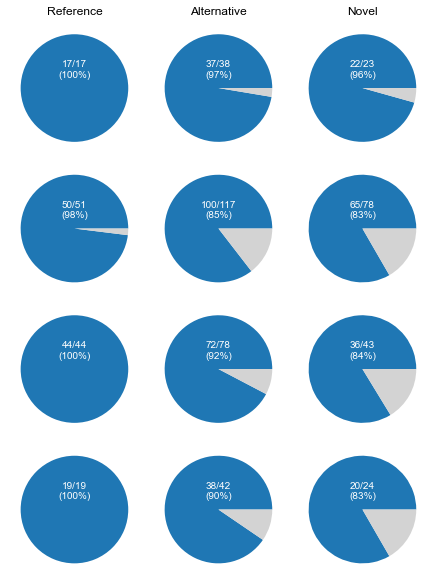

In [8]:
fig, axes = plt.subplots(4, 3)
fig.set_size_inches(6, 8)
cats = ['reference', 'alternative', 'novel']
for cat, ax in zip(cats, axes[0, :]):
    ax.set_title(cat.capitalize())
    tested_iso = (iso['valid_ppi_test'] & 
                  iso['at_least_two_fold_activation'].notnull() &
                  iso['at_least_one_pdi'].notnull() &
                  (iso['category'] == cat))
    cnt = ((iso.loc[tested_iso, 'at_least_one_ppi'] |
            iso.loc[tested_iso, 'at_least_two_fold_activation'] |
            iso.loc[tested_iso, 'at_least_one_pdi']) 
           .value_counts())
    cnt.plot.pie(ax=ax,
                 labels=['', ''],
                 colors=['C0', 'lightgrey'])
    ax.text(x=0, 
            y=0.2, 
            s='{}/{}\n({:.0%})'.format(cnt[True], cnt.sum(), cnt[True] / cnt.sum()),
            ha='center',
            color='white')
    ax.set_ylabel('')
for cat, ax in zip(cats, axes[1, :]):
    tested_iso = (iso['valid_ppi_test'] & 
                    iso['at_least_two_fold_activation'].notnull() &
                    (iso['category'] == cat))
    cnt = ((iso.loc[tested_iso, 'at_least_one_ppi'] | iso.loc[tested_iso, 'at_least_two_fold_activation']) 
           .value_counts())
    cnt.plot.pie(ax=ax,
                 labels=['', ''],
                 colors=['C0', 'lightgrey'])
    ax.text(x=0, 
            y=0.2, 
            s='{}/{}\n({:.0%})'.format(cnt[True], cnt.sum(), cnt[True] / cnt.sum()),
            ha='center',
            color='white')
    ax.set_ylabel('')
for cat, ax in zip(cats, axes[2, :]):
    tested_iso = (iso['at_least_one_pdi'].notnull() & 
                    iso['at_least_two_fold_activation'].notnull() &
                    (iso['category'] == cat))
    cnt = ((iso.loc[tested_iso, 'at_least_one_pdi'] | iso.loc[tested_iso, 'at_least_two_fold_activation']) 
           .value_counts())
    cnt.plot.pie(ax=ax,
                 labels=['', ''],
                 colors=['C0', 'lightgrey'])
    ax.text(x=0, 
            y=0.2, 
            s='{}/{}\n({:.0%})'.format(cnt[True], cnt.sum(), cnt[True] / cnt.sum()),
            ha='center',
            color='white')
    ax.set_ylabel('')
for cat, ax in zip(cats, axes[3, :]):
    tested_iso = (iso['at_least_one_pdi'].notnull() & 
                    iso['valid_ppi_test'] &
                    (iso['category'] == cat))
    cnt = ((iso.loc[tested_iso, 'at_least_one_pdi'] | iso.loc[tested_iso, 'at_least_one_ppi']) 
           .value_counts())
    cnt.plot.pie(ax=ax,
                 labels=['', ''],
                 colors=['C0', 'lightgrey'])
    ax.text(x=0, 
            y=0.2, 
            s='{}/{}\n({:.0%})'.format(cnt[True], cnt.sum(), cnt[True] / cnt.sum()),
            ha='center',
            color='white')
    ax.set_ylabel('')
plt.savefig('../figures/fraction_positive_by_isoform_type_this_or_that.pdf',
            bbox_inches='tight')

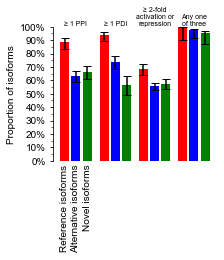

In [9]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=3, h=3.5)
cats = ['reference', 'alternative', 'novel']
positives = []
tested = []
for cat in cats:
    positives.append(iso.loc[iso['valid_ppi_test'] &
                        (iso['category'] == cat),
                        'at_least_one_ppi'].sum())
    tested.append(iso.loc[iso['valid_ppi_test'] &
                        (iso['category'] == cat),
                        'at_least_one_ppi'].notnull().sum())
for cat in cats:
    positives.append(iso.loc[
                        (iso['category'] == cat),
                        'at_least_one_pdi'].sum())
    tested.append(iso.loc[
                        (iso['category'] == cat),
                        'at_least_one_pdi'].notnull().sum())
for cat in cats:
    positives.append(iso.loc[
                        (iso['category'] == cat),
                        'at_least_two_fold_activation'].sum())
    tested.append(iso.loc[
                        (iso['category'] == cat),
                        'at_least_two_fold_activation'].notnull().sum())
for cat in cats:
    tested_iso = (iso['valid_ppi_test'] & 
                    iso['at_least_two_fold_activation'].notnull() &
                    iso['at_least_one_pdi'].notnull() &
                    (iso['category'] == cat))
    positives.append((iso.loc[tested_iso, 'at_least_one_ppi'] |
                 iso.loc[tested_iso, 'at_least_two_fold_activation'] |
                 iso.loc[tested_iso, 'at_least_one_pdi']).sum())
    tested.append(tested_iso.sum())
    
vals = [p / n for p, n in zip(positives, tested)]
#errs = [np.sqrt(((p / n) * (1 - (p / n)) / n)) for p, n in zip(positives, tested)]

pos = np.array(positives)
neg = np.array(tested) - pos
fracs = np.array(vals)
intv = stats.beta.interval(0.6827, pos + 1, neg + 1)
errs = [fracs - intv[0], intv[1] - fracs]
errs[0][pos == 0] = 0.
errs[1][neg == 0] = 0.

offset = 0.5
x_pos = ([i for i in range(3)] + 
       [i + offset for i in range(3, 6)] + 
       [i + offset * 2 for i in range(6, 9)] +
       [i + offset * 3 for i in range(9, 12)])
ax.bar(x=x_pos, height=vals, color=['red', 'blue', 'green'] * 3)
ax.errorbar(x=x_pos, y=vals, yerr=errs,
            color='black',
            fmt='none',
            capsize=4)
ax.set_ylim(0, 1)
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_yticks(np.linspace(0, 1, 21), minor=True)
ax.set_yticklabels([f'{y:.0%}' for y in ax.get_yticks()])
for loc in ['top', 'bottom', 'right']:
    ax.spines[loc].set_visible(False)
ax.xaxis.set_tick_params(length=0)
ax.set_xticks([0, 1, 2])
# TODO: color the labels
ax.set_xticklabels(['Reference isoforms', 
                    'Alternative isoforms',
                    'Novel isoforms'], rotation=90)
ax.set_ylabel('Proportion of isoforms')
ax.text(y=1, x=x_pos[1], s='≥ 1 PPI', 
        fontsize=7,
        va='bottom', ha='center')
ax.text(y=1, x=x_pos[4], s='≥ 1 PDI',
        fontsize=7,
        va='bottom', ha='center')
ax.text(y=1, x=x_pos[7], s='≥ 2-fold\nactivation or\nrepression',
        fontsize=7, 
        va='bottom', ha='center')
ax.text(y=1, x=x_pos[10], s='Any one\nof three', 
        fontsize=7,
        va='bottom', ha='center')
fig.savefig('../figures/at-least-some-assay-result_ref-vs-alt-vs-novel_bar.pdf',
            bbox_inches='tight')
# colors?

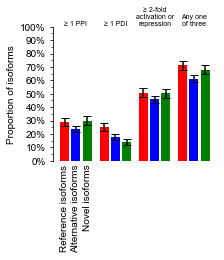

In [10]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=3, h=3.5)
cats = ['reference', 'alternative', 'novel']
positives = []
tested = []
for cat in cats:
    positives.append(iso.loc[iso['valid_ppi_test'] &
                        (iso['category'] == cat),
                        'at_least_one_ppi'].sum())

for cat in cats:
    positives.append(iso.loc[
                        (iso['category'] == cat),
                        'at_least_one_pdi'].sum())

for cat in cats:
    positives.append(iso.loc[
                        (iso['category'] == cat),
                        'at_least_two_fold_activation'].sum())

for cat in cats:
    positives.append((iso.loc[(iso['category'] == cat), 'at_least_one_ppi'].fillna(False) |
                      iso.loc[(iso['category'] == cat), 'at_least_two_fold_activation'].fillna(False) |
                      iso.loc[(iso['category'] == cat), 'at_least_one_pdi'].fillna(False)).sum())    

tested = [(iso['category'] == cat).sum() for cat in cats] * 4
vals = [p / n for p, n in zip(positives, tested)]

pos = np.array(positives)
neg = np.array(tested) - pos
fracs = np.array(vals)
intv = stats.beta.interval(0.6827, pos + 1, neg + 1)
errs = [fracs - intv[0], intv[1] - fracs]
errs[0][pos == 0] = 0.
errs[1][neg == 0] = 0.

offset = 0.5
x_pos = ([i for i in range(3)] + 
       [i + offset for i in range(3, 6)] + 
       [i + offset * 2 for i in range(6, 9)] +
       [i + offset * 3 for i in range(9, 12)])
ax.bar(x=x_pos, height=vals, color=['red', 'blue', 'green'] * 3)
ax.errorbar(x=x_pos, y=vals, yerr=errs,
            color='black',
            fmt='none',
            capsize=4)
ax.set_ylim(0, 1)
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_yticks(np.linspace(0, 1, 21), minor=True)
ax.set_yticklabels([f'{y:.0%}' for y in ax.get_yticks()])
for loc in ['top', 'bottom', 'right']:
    ax.spines[loc].set_visible(False)
ax.xaxis.set_tick_params(length=0)
ax.set_xticks([0, 1, 2])
# TODO: color the labels
ax.set_xticklabels(['Reference isoforms', 
                    'Alternative isoforms',
                    'Novel isoforms'], rotation=90)
ax.set_ylabel('Proportion of isoforms')
ax.text(y=1, x=x_pos[1], s='≥ 1 PPI', 
        fontsize=7,
        va='bottom', ha='center')
ax.text(y=1, x=x_pos[4], s='≥ 1 PDI',
        fontsize=7,
        va='bottom', ha='center')
ax.text(y=1, x=x_pos[7], s='≥ 2-fold\nactivation or\nrepression',
        fontsize=7, 
        va='bottom', ha='center')
ax.text(y=1, x=x_pos[10], s='Any one\nof three', 
        fontsize=7,
        va='bottom', ha='center')
fig.savefig('../figures/at-least-some-assay-result_ref-vs-alt-vs-novel_absolute_bar.pdf',
            bbox_inches='tight')